In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reload library
from importlib import reload

# Local application imports
import smile.smile; reload(smile.smile)
from smile.smile import PopulationList, Methodology, RegressionResultList, RegressionResult
import smile.example_populations; reload(smile.example_populations)
import smile.helper; reload(smile.helper)
import smile.global_params; reload(smile.global_params);

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

# Population generation

In [4]:
pops_noerror, pops_mulerror, pops_adderror = smile.example_populations.get_useful_poplists(100)
    
pops_noerror.generate()
pops_mulerror.generate()
pops_adderror.generate()

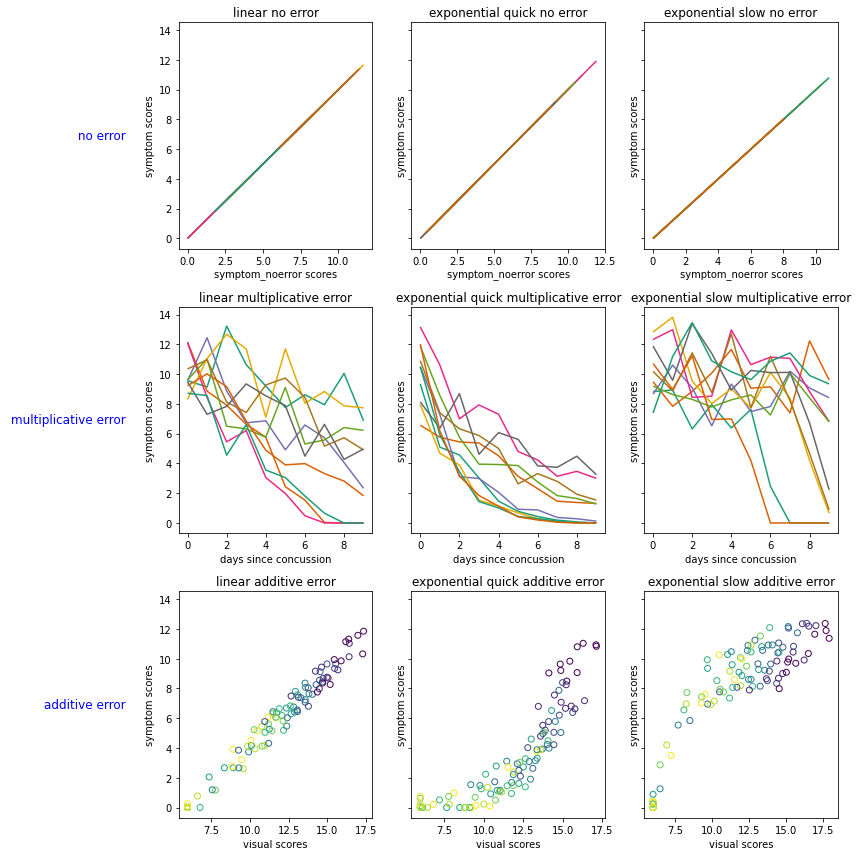

In [5]:
ncols = len(pops_noerror)
nrows = len([pops_noerror, pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, sharey=True)
npersons=10
ndays=10

pops_noerror.plot(axes[0, :], x='symptom_noerror', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_mulerror.plot(axes[1, :], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_adderror.plot(axes[2, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

# Study

## Comparing traditional studies

In [6]:
pops = pops_mulerror

In [7]:
methodologies = [Methodology('trad short', [8, 15, 29]), Methodology('trad long', [8, 29, 90])]

meth_pops = []
for methodology in methodologies:
    meth_pops.append(methodology.sample(pops))

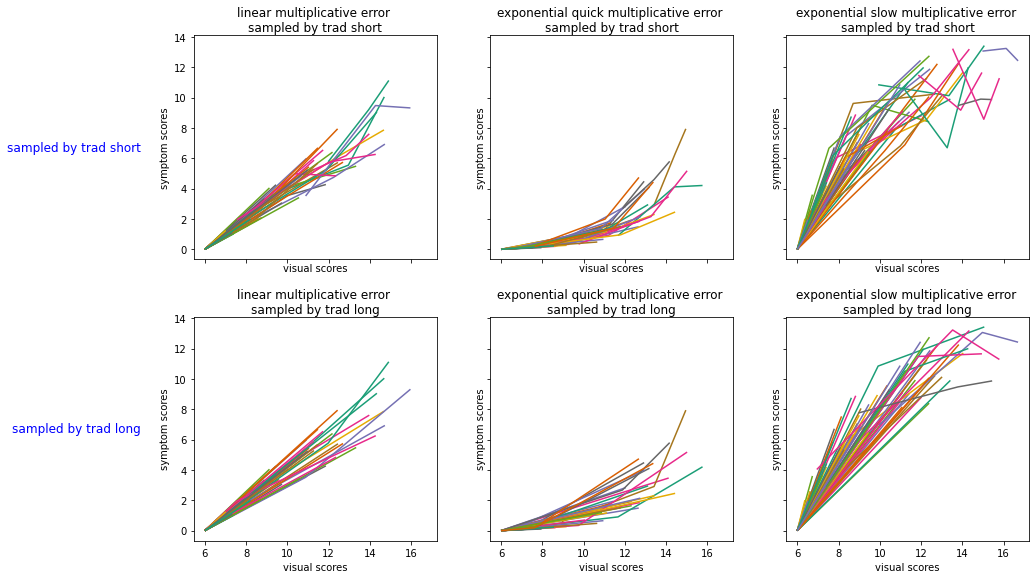

In [8]:
ncols = len(meth_pops[0])
nrows = len(meth_pops)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops[row].plot(axes[row, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
fig.subplots_adjust(left=0.005, top=0.95)
plt.show()

## Comparing traditional to smile studies

In [9]:
pops = pops_adderror

In [10]:
methodologies2 = [Methodology('trad short', [8, 15, 29, 90]), Methodology('smile', [8, 0.7, 0.4, 0.1])]

meth_pops2 = []
for methodology in methodologies2:
    meth_pops2.append(methodology.sample(pops))

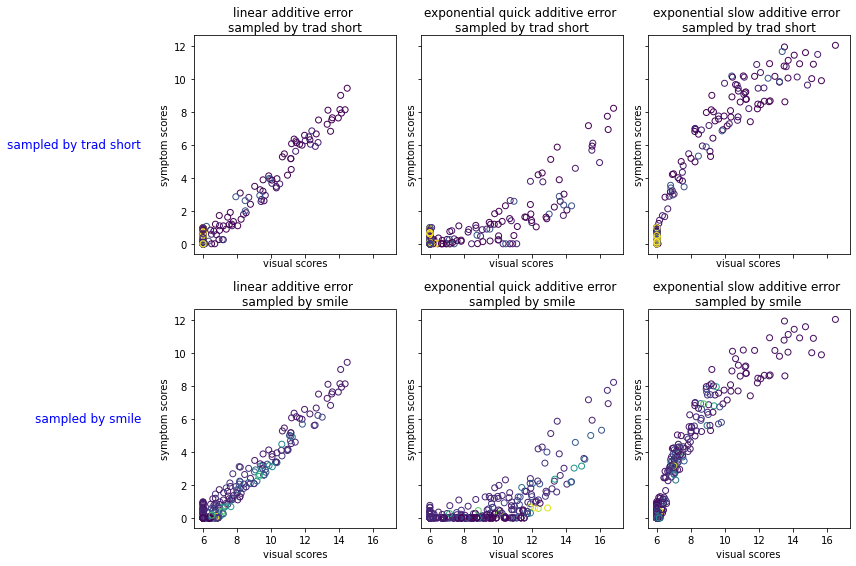

In [11]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops2[row].plot(axes[row, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Mixed Effects Regression
(Without sampling nor filtering)

In [12]:
npersons = 10
npops = 30
#See run times in later markdown cell

pops_noerror, pops_mulerror, pops_adderror = smile.example_populations.get_useful_poplists(npersons)

list_of_poplists = [PopulationList.full(npops, pops_noerror[0]), PopulationList.full(npops, pops_mulerror[0]), PopulationList.full(npops, pops_adderror[0])]

for poplist in list_of_poplists:
    poplist.generate()

In [13]:
from datetime import datetime
print(datetime.now().strftime("%H:%M"))

13:46


In [14]:

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #likev = mdf.profile_re(0, 're', dist_low=0.1, dist_high=0.1)
    #https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

    list_of_results = []
    for poplist in list_of_poplists:
        start = datetime.now()
        
        list_of_results.append(poplist.regress_mixed())
        
        end = datetime.now()
        delta = int((end-start).total_seconds())
        print(f"Took {delta//60} minutes {delta%60} seconds to run {poplist.title} for npersons={npersons}, npops={npops}")

Took 0 minutes 49 seconds to run list of linear no error for npersons=10, npops=30
Took 0 minutes 44 seconds to run list of linear multiplicative error for npersons=10, npops=30
Took 0 minutes 47 seconds to run list of linear additive error for npersons=10, npops=30


**Mixed regression run times:**

|            | npops |   10   |   30   |   100  |
|------------|-------|--------|--------|--------|
|**npersons**|       |        |        |        |
|**10**      |       |**20 s**|**20 s**|**15 s**|
|**30**      |       |**2 m** | **2 m**| **2 m**|
|**100**     |       |**25 m**|**25 m**|**25 m**|

Also: took 2 minutes 46 seconds to run for npersons=10, npops=100 (weird, never so slow) (happened twice!)

Also: took 0 minutes 43 seconds to run for npersons=10, npops=30

Also: took 15, 13, 11 seconds to run for npersons=10, npops=10

Also: took 49, 42, 39 seconds to run for npersons=10, npops=30

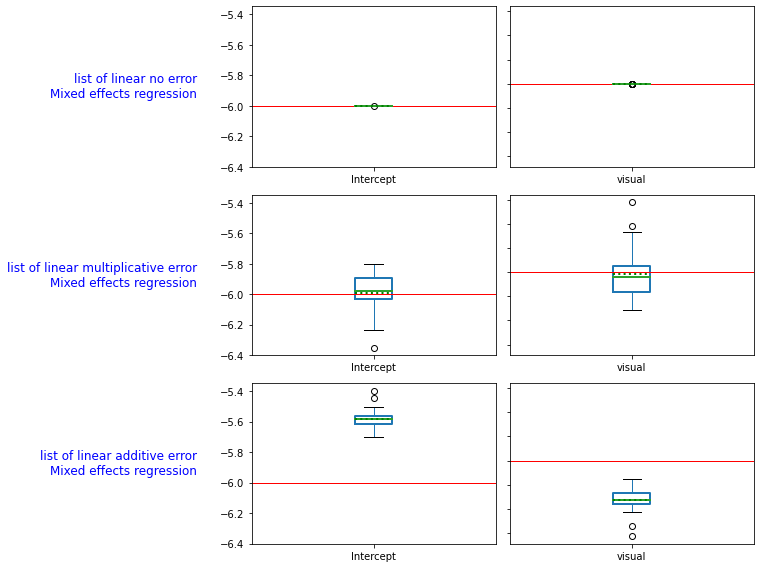

In [15]:
ncols = 2 #number of parameters, TODO
nrows = len(list_of_results)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(0.5*nrows/ncols)*2, sharey='col', squeeze=False)

for row in range(nrows):
    slope_truth = 1
    intercept_truth = slope_truth * -smile.global_params.VMIN
    list_of_results[row].plot_box(axes[row], ground_truths=[intercept_truth, slope_truth])
        
plt.tight_layout()
plt.show()
#dotted green line is the mean, solid green line is the median

In [16]:
import pandas as pd

list_of_biases = [results.get_biases([intercept_truth, slope_truth], magnitude=False, relative=True) for results in list_of_results]
df_of_biases = pd.concat(list_of_biases, axis=1).transpose()
df_of_biases.index = [poplist.title for poplist in list_of_poplists]
def format_fn(val):
    if abs(val) < 1e-4: return f'{val:<.2e} %'
    elif abs(val) < 1e-3: return f'{val:.4f} %'
    elif abs(val) < 1e-2: return f'{val:.3f} %'
    else: return f'{val:.2f} %'
df_of_biases_formatted = df_of_biases.style.format({key:format_fn for key in df_of_biases.columns})
df_of_biases_formatted

,Intercept (%),visual (%)
list of linear no error,-2.21e-12 %,6.21e-11 %
list of linear multiplicative error,-0.18 %,-0.18 %
list of linear additive error,-6.94 %,-3.23 %
